<a href="https://colab.research.google.com/github/cathay/cnn/blob/master/eroad_driver_action_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import zipfile
import random
import tensorflow as tf
from shutil import copyfile
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

#Import Google drive functions
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import shutil
shutil.rmtree('tmp')

In [0]:
import shutil
DRIVE_PATH = '/content/drive/My Drive/colab/'
TRAIN_FILE = 'Thay_data_table.zip'

shutil.copyfile(DRIVE_PATH + TRAIN_FILE, TRAIN_FILE)

zip_ref = zipfile.ZipFile('Thay_data_table.zip', 'r')
zip_ref.extractall('tmp')
zip_ref.close()

In [0]:
from keras.utils import to_categorical

def get_im_cv2(path, w, h):
  img = cv2.imread(path)
  resized = cv2.resize(img, (w,h), cv2.INTER_LINEAR) 
  return resized

TRAINING_DIR = 'tmp/Thay_data'
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

files = []
categories = []
paths = []

actions = {
    'normal' : 0,
    'drinking': 1,
    'phone_left' : 2,
    'phone_right' : 3,
    #'texting_left': 2,
}

NUM_CLASSESS = len(actions.keys())

#Should add class 0
for i in range(1,2):
  for dir_name in actions.keys():
    for file in os.listdir("%s_%s/%s" % (TRAINING_DIR, i, dir_name)):
      if(file.endswith('png')): #('.png', '.jpg', '.jpeg')
        files.append(file)
        categories.append(actions.get(dir_name))
        paths.append("%s_%s/%s/%s" %(TRAINING_DIR, i, dir_name, file))

df = pd.DataFrame({'file': files,
                   'category': categories,
                   'path': paths
                  })

df['Y'] = df['category'].map(lambda x: to_categorical(x, NUM_CLASSESS, dtype='uint8'))
df['X'] = df['path'].map(lambda path: get_im_cv2(path, IMAGE_WIDTH, IMAGE_HEIGHT))

In [9]:

#df.size
print("files:%s, paths size: %s, df[X]size: %s" % (len(files), len(paths), df['X'].size))
#df.sample(20, axis=None)

files:484, paths size: 484, df[X]size: 484


In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

x_train = []
x_test = []
y_train = []
y_test= []

for item in train_df['X']:
  x_train.append(item)

for item in validate_df['X']:
  x_test.append(item)

for item in train_df['Y']:
  y_train.append(item)

for item in validate_df['Y']:
  y_test.append(item)

x_train = np.array(x_train, dtype=np.uint8)
x_test = np.array(x_test, dtype=np.uint8)
y_train = np.array(y_train, dtype=np.uint8)
y_test = np.array(y_test, dtype=np.uint8)

In [11]:
#build model
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.python.keras import Sequential
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.applications.resnet50 import ResNet50

#from keras.models import Sequential
#from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
#from keras.optimizers import RMSprop, SGD
#from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

model = Sequential()
model.add(base_model)

model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax')) # 

for layer in base_model.layers:
    layer.trainable = False

#model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

#model.summary()

## Train
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import preprocess_input

earlystop = EarlyStopping(patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
EPOCHS=10
BATCH_SIZE=15
callbacks = [learning_rate_reduction]

history = model.fit(x_train, 
                    y_train,
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, y_test))
                    #,callbacks=callbacks)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/10
26/26 [==============================] - 4s 145ms/step - loss: 0.7598 - accuracy: 0.7080 - val_loss: 0.0320 - val_accuracy: 0.9794
Epoch 2/10
26/26 [==============================] - 2s 79ms/step - loss: 0.1021 - accuracy: 0.9742 - val_loss: 0.0254 - val_accuracy: 1.0000
Epoch 3/10
26/26 [==============================] - 2s 80ms/step - loss: 0.0710 - accuracy: 0.9871 - val_loss: 0.0255 - val_accuracy: 1.0000
Epoch 4/10
26/26 [==============================] - 2s 79ms/step - loss: 0.0576 - accuracy: 0.9922 - val_loss: 0.0247 - val_accuracy: 1.0000
Epoch 5/10
26/26 [==============================] - 2s 79ms/step - loss: 0.0356 - accuracy: 1.0000 - val_loss: 0.0274 - val_accuracy: 1.0000
Epoch 6/10
26/26 [==============================] - 2s 79ms/step - loss: 0.0592 - accuracy: 0.9819 - val_loss: 0.0255 - val_accuracy: 1.0000
Epoch 7/10
26/26 [==============================] - 2s 79ms/step - loss: 0.0380 - accura

In [12]:
model.save('eroad_action_detection_resnet_10_epoch.h5')
shutil.copyfile('eroad_action_detection_resnet_10_epoch.h5', DRIVE_PATH + 'eroad_action_detection_resnet_10_epoch.h5')

'/content/drive/My Drive/colab/eroad_action_detection_resnet_10_epoch.h5'

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg
[0.07091585 0.02545493 0.7894567  0.11417251]
2
Classified: phone_left


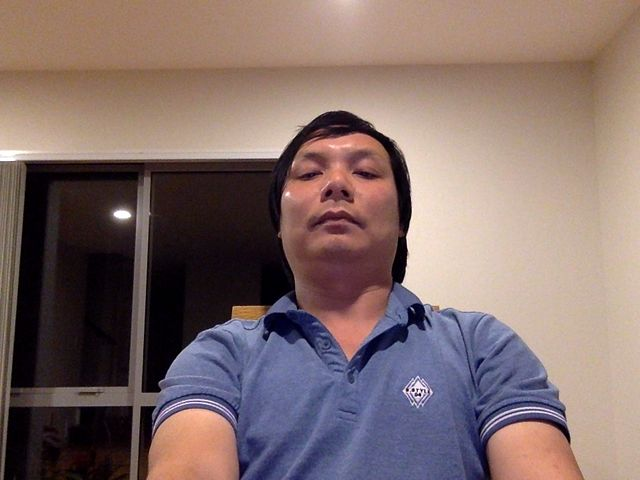

In [28]:
label_map = {
    0: 'normal',
    1: 'drinking',
    2: 'phone_left',
    3: 'phone_right'
}

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  img = get_im_cv2(filename, IMAGE_WIDTH, IMAGE_HEIGHT)

  x_predict=[]
  x_predict.append(img)
  x_predict = np.array(x_predict, dtype=np.uint8)
  prediction = model.predict(x_predict);

  label = np.argmax(prediction)

  print(*prediction) 
  print(label)
  print("Classified: %s" % (label_map.get(label)))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))